In [145]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import copy

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
import QuantLib as ql

In [147]:
today = ql.Date().todaysDate()

In [148]:
payoff = ql.PlainVanillaPayoff(ql.Option.Call, 100)
exercise = ql.EuropeanExercise(ql.Date(20, 6, 2024))
european_option = ql.VanillaOption(payoff, exercise)

In [149]:
initialValue = ql.QuoteHandle(ql.SimpleQuote(100))
riskFreeTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0, ql.Actual365Fixed()))
dividendTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0, ql.Actual365Fixed()))


hestonProcess = ql.HestonProcess(riskFreeTS, dividendTS, initialValue, 0.0392, 0.1, 0.3156, 0.331, -0.681)
engine = ql.AnalyticHestonEngine(ql.HestonModel(hestonProcess), 0.01, 1001)
european_option.setPricingEngine(engine)
h_price = european_option.NPV()
print("The Heston model price is",h_price)

The Heston model price is 12.447046690974886


In [150]:
from pricing.rheston import RoughHestonFast

rheston = RoughHestonFast()
r = 0
params = {
    'mu': r,
    'corr': 0,
    'h2': 0.4999,

    'v0': 0.0392,
    'v_mr': 0.1,
    'v_mu': 0.3156,
    'v_vol': 0.0331
}
rheston.set_parameters(**params)

T = 2
size = 1001
dt = T / size
S0 = 100

Heston: Simulating 1 dws
Heston: Simulating 1 dws


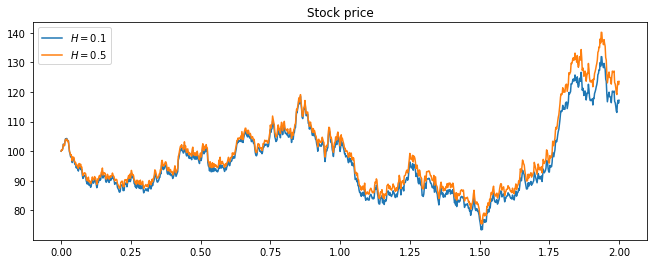

In [151]:
rheston.set_parameters(mu=0)
rheston.set_parameters(h2=0.4999)
path5 = rheston.simulate(S0, T, size, return_path=True, seed=42)
rheston.set_parameters(h2=0.1)
path1 = rheston.simulate(S0, T, size, return_path=True, seed=42)

plt.figure(figsize=(11, 4))
plt.plot(np.linspace(0, T, size), path1, label='$H = 0.1$')
plt.plot(np.linspace(0, T, size), path5, label='$H = 0.5$')
plt.title('Stock price')
plt.legend()
plt.show()

Heston: Simulating 1 dws
Heston: Simulating 1 dws


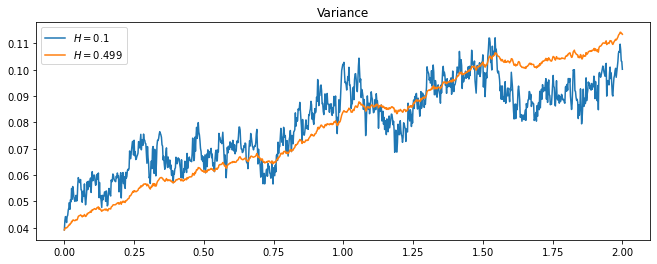

In [152]:
rheston.set_parameters(mu=0)
rheston.set_parameters(h2=0.4999)
path5 = rheston.simulate(S0, T, size, return_path=True, seed=42)
path5 = np.squeeze(rheston.last_v_path)
rheston.set_parameters(h2=0.1)
path1 = rheston.simulate(S0, T, size, return_path=True, seed=42)
path1 = np.squeeze(rheston.last_v_path)

plt.figure(figsize=(11, 4))
plt.plot(np.linspace(0, T, size), path1, label='$H = 0.1$')
plt.plot(np.linspace(0, T, size), path5, label='$H = 0.499$')
plt.title('Variance')
plt.legend()
plt.show()

In [199]:
r = 0
params = {
    'mu': r,
    'corr': -0.681,
    'h2': 0.4999,

    'v0': 0.0392,
    'v_mr': 0.1,
    'v_mu': 0.3156,
    'v_vol': 0.0331
}

In [154]:
ql.Settings.instance().evaluationDate = ql.Date(20, 6, 2022)
exercise = ql.EuropeanExercise(ql.Date(20, 6, 2024))
european_option = ql.VanillaOption(payoff, exercise)

initialValue = ql.QuoteHandle(ql.SimpleQuote(100))
riskFreeTS = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
dividendTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0, ql.Actual365Fixed()))


hestonProcess = ql.HestonProcess(riskFreeTS, dividendTS, initialValue, params['v0'], 
    params['v_mr'], params['v_mu'], params['v_vol'], params['corr'])
engine = ql.AnalyticHestonEngine(ql.HestonModel(hestonProcess), 0.01, 1001)

Ks = np.array([80, 90, 100, 110, 120], dtype=float)
ql_prices = Ks.copy()
for ind, k in enumerate(Ks):
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, k)
    european_option = ql.VanillaOption(payoff, exercise)
    european_option.setPricingEngine(engine)
    h_price = european_option.NPV()
    ql_prices[ind] = h_price

print(ql_prices)

[25.34280325 19.19377591 14.23698547 10.36987907  7.43577782]


In [155]:
rheston.set_parameters(**params)

In [203]:
from pricing.price_engine import MontelCarloOptionPricingEngine

pricer = MontelCarloOptionPricingEngine(rheston)
trials = 20
classic_rough_price = np.zeros((trials, len(Ks)))
np.random.seed(42)
for i in range(trials):
    price = pricer.european_call_option_price(S0, Ks, r, T, 250, batch_num=10, quiet=True)
    classic_rough_price[i] = price
    print(f'{i}', end='\r')
print(classic_rough_price)

KeyboardInterrupt: 

In [158]:
import scipy.stats as st

def find_interval(confidence, vec):
    return st.t.interval(confidence, len(vec)-1, loc=np.mean(vec), scale=st.sem(vec))

In [210]:
np.random.seed(150)
rheston.set_parameters(h2=0.4999)
print(pricer.model.p)
prices = pricer.european_call_option_price_sim(S0, Ks, r, T, 250, batch_num=10, quiet=True)
for ind, k in enumerate(Ks):
    interval = find_interval(0.95, prices[:,ind])
    print(f"{k}: mean({np.mean(prices[:,ind])}) cf int({interval})")

{'mu': 0, 'corr': -0.681, 'h2': 0.4999, 'v0': 0.0392, 'v_mr': 0.1, 'v_mu': 0.3156, 'v_vol': 0.0331, 'tol': 1e-06}
80.0: mean(25.358364744617223) cf int((25.167151704568628, 25.549577784665818))
90.0: mean(19.19720428234987) cf int((19.023799786566567, 19.37060877813317))
100.0: mean(14.212451687200288) cf int((14.058482292550002, 14.366421081850573))
110.0: mean(10.324470814697479) cf int((10.190266997567232, 10.458674631827726))
120.0: mean(7.378674570539324) cf int((7.263489158386341, 7.493859982692308))


In [214]:
np.random.seed(140)
rheston.set_parameters(h2=0.12)
print(pricer.model.p)
prices = pricer.european_call_option_price_sim(S0, Ks, r, T, 250, batch_num=10, quiet=True)
for ind, k in enumerate(Ks):
    interval = find_interval(0.95, prices[:,ind])
    print(f"{k}: mean({np.mean(prices[:,ind])}) cf int({interval})")

{'mu': 0, 'corr': -0.681, 'h2': 0.12, 'v0': 0.0392, 'v_mr': 0.1, 'v_mu': 0.3156, 'v_vol': 0.0331, 'tol': 1e-06}
80.0: mean(25.441618001618664) cf int((25.24978321544399, 25.63345278779334))
90.0: mean(19.271495031203138) cf int((19.09743045085569, 19.445559611550586))
100.0: mean(14.28901558326975) cf int((14.134406039341405, 14.443625127198095))
110.0: mean(10.404835586382159) cf int((10.270046565933464, 10.539624606830854))
120.0: mean(7.453180114198534) cf int((7.3374811411095155, 7.568879087287552))


In [206]:
print(np.mean(prices, axis = 0))

[25.08427701 18.94437665 14.00357858 10.17052889  7.26237925]


In [202]:
for ind, k in enumerate(Ks):
    interval = find_interval(0.95, classic_rough_price[:,ind])
    print(f"{k}: mean({np.mean(classic_rough_price[:,ind])}) cf int({interval})")

80.0: mean(25.392290319782) cf int((25.337182510301368, 25.44739812926263))
90.0: mean(19.23158075087472) cf int((19.183561848340275, 19.279599653409164))
100.0: mean(14.26156083815533) cf int((14.219961790162428, 14.303159886148231))
110.0: mean(10.382600958052267) cf int((10.347619430862, 10.417582485242534))
120.0: mean(7.438706568945882) cf int((7.409338898929826, 7.468074238961939))


In [177]:
r = 0
params = {
    'mu': r,
    'corr': -0.681,
    'h2': 0.12,

    'v0': 0.0392,
    'v_mr': 0.1,
    'v_mu': 0.3156,
    'v_vol': 0.0331
}

In [161]:
from fbm.utils import FunctionTimer

In [194]:
rheston = RoughHestonFast()
pricer = MontelCarloOptionPricingEngine(rheston)
trials = 10
rough_prices = np.zeros((trials, len(Ks)))
times = np.zeros(trials)
rheston.set_parameters(**params)
np.random.seed(45)
for i in range(trials):
    timer = FunctionTimer()
    price = pricer.european_call_option_price(S0, Ks, r, T, 251, batch_num=10, quiet=True)
    times[i] = timer.stop()
    rough_prices[i] = price
    print(price)
print(rough_prices)

[25.24687984 19.09772269 14.15000211 10.28824141  7.36699555]
[25.02355677 18.90740036 13.98890976 10.16059082  7.26500559]
[25.40148867 19.24627304 14.28676975 10.41945621  7.47835789]
[25.29964025 19.1582669  14.20421242 10.32774053  7.38782159]
[25.13516053 19.00681101 14.06685806 10.21285134  7.29544625]
[25.380887   19.23664294 14.26761096 10.38005297  7.43521932]
[25.19829977 19.07046255 14.14221678 10.30477277  7.39875537]
[25.44330742 19.25809019 14.26172002 10.36979689  7.41765519]
[25.4406482  19.28448714 14.31262075 10.42981032  7.47996564]
[25.31136153 19.16071637 14.19293728 10.32296133  7.38332846]
[[25.24687984 19.09772269 14.15000211 10.28824141  7.36699555]
 [25.02355677 18.90740036 13.98890976 10.16059082  7.26500559]
 [25.40148867 19.24627304 14.28676975 10.41945621  7.47835789]
 [25.29964025 19.1582669  14.20421242 10.32774053  7.38782159]
 [25.13516053 19.00681101 14.06685806 10.21285134  7.29544625]
 [25.380887   19.23664294 14.26761096 10.38005297  7.43521932]
 [

In [195]:
for ind, k in enumerate(Ks):
    interval = find_interval(0.95, rough_prices[:,ind])
    print(f"{k}: mean({np.mean(rough_prices[:,ind])}) cf int({interval})")

80.0: mean(25.288122995900864) cf int((25.18904677659641, 25.387199215205317))
90.0: mean(19.142687317174016) cf int((19.05520066589787, 19.23017396845016))
100.0: mean(14.187385789776547) cf int((14.113814840801428, 14.260956738751666))
110.0: mean(10.321627459799757) cf int((10.260270233837224, 10.38298468576229))
120.0: mean(7.390855083693502) cf int((7.3408810621896095, 7.440829105197395))
